In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 100

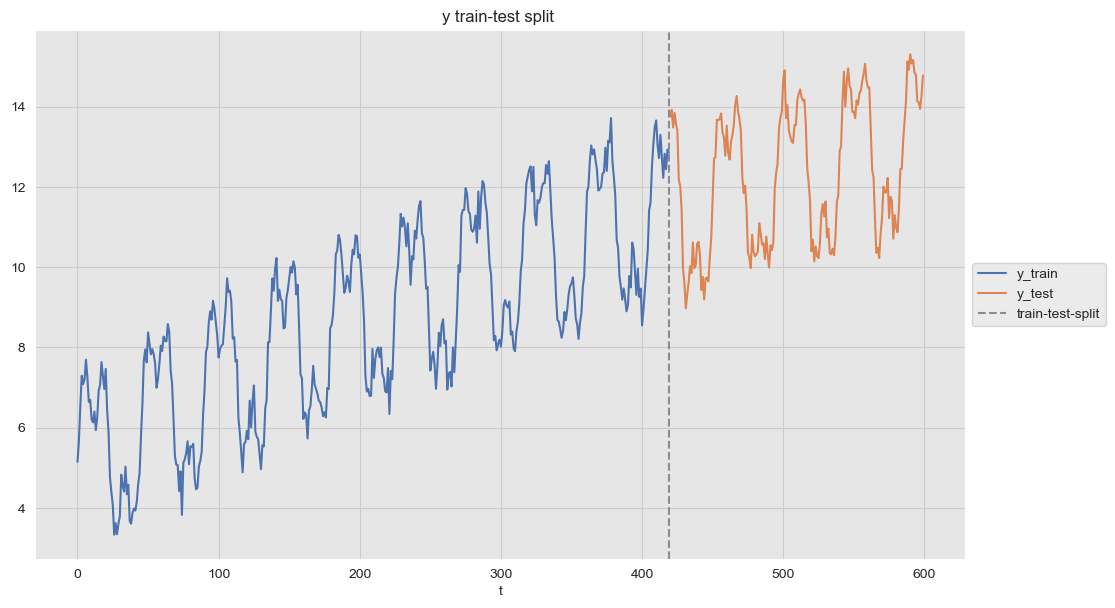

In [51]:
np.random.seed(42)

# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi*t)/period) 

def generate_data(n, sigma_n = 0.3):
    """Generate sample data. 
    Two seasonal components, one linear trend and gaussian noise.
    """
    # Define "time" variable.
    t = np.arange(n)
    data_df = pd.DataFrame({'t' : t})
    # Add components:
    data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
    data_df['s1'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=2, period=45)) 
    data_df['s2'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=1, period=15)) 
    data_df['tr1'] = 0.5 * np.sqrt(data_df['t'] + 100)
    return data_df.eval('y = s1 + s2 + tr1 + epsilon')


# Number of samples.
n = 600
# Generate data.
data_df = generate_data(n=n)

x = data_df['t'].values
y = data_df['y'].values

prop_train = 0.7
n_train = round(prop_train * n)
n_test = n - n_train

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train, y=y_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test, y=y_test, color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='');

In [79]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

model = ETSModel(
    endog=y_train,
    error='additive',
    trend='add',
    seasonal='additive',
    seasonal_periods=45,
)

result = model.fit()

print(result.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  420
Model:                       ETS(AAA)   Log Likelihood                 -66.734
Date:                Sat, 27 Feb 2021   AIC                            235.468
Time:                        12:37:09   BIC                            441.521
Sample:                             0   HQIC                           316.910
                                - 420   Scale                            0.080
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0749      0.014      5.204      0.000       0.047       0.103
smoothing_trend      7.489e-06        nan        nan        nan         nan         nan
smoothing_season

In [68]:
y_train_pred = result.predict()
y_test_pred = result.forecast(n_test)

In [69]:
train_simulations  = result.simulate(nsimulations=n_train, anchor='start', repetitions=1000)
test_simulations  = result.simulate(nsimulations=n_test, anchor='end', repetitions=1000)

train_sim_mean = train_simulations.mean(axis=1)
train_sim_std = train_simulations.std(axis=1)
train_sim_plus = train_sim_mean + 2*train_sim_std
train_sim_minus = train_sim_mean - 2*train_sim_std

test_sim_mean = test_simulations.mean(axis=1)
test_sim_std = test_simulations.std(axis=1)
test_sim_plus = test_sim_mean + 2*test_sim_std
test_sim_minus = test_sim_mean - 2*test_sim_std

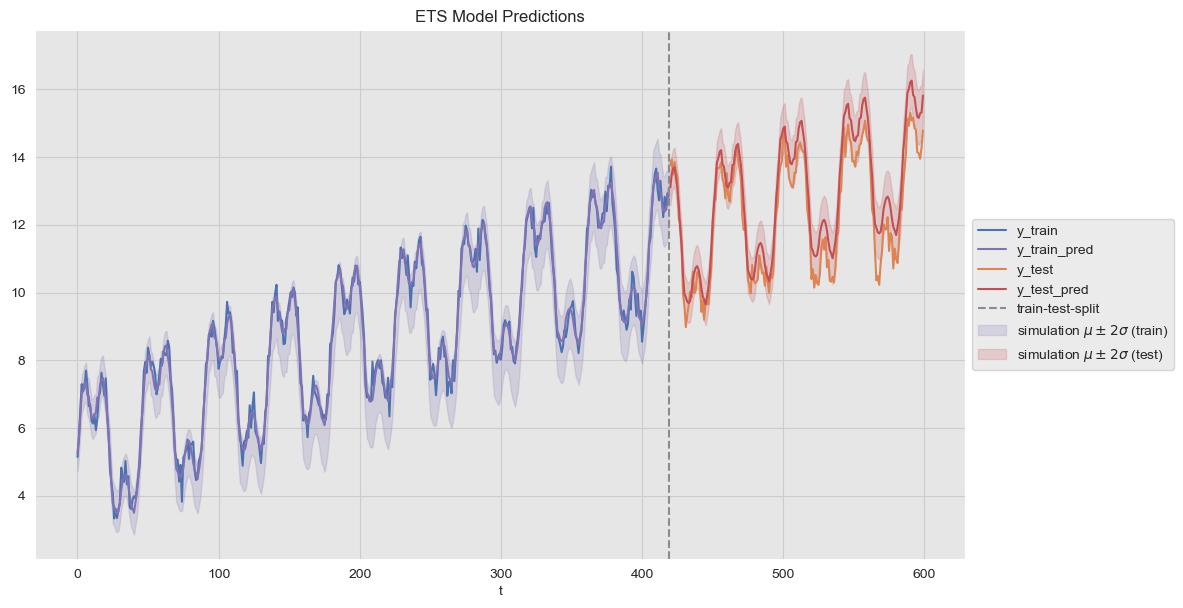

In [70]:
fig, ax = plt.subplots()
sns.lineplot(x=x_train, y=y_train, color=sns_c[0], label='y_train', ax=ax)
ax.fill_between(
    x=x_train, 
    y1=train_sim_minus, 
    y2=train_sim_plus, 
    color=sns_c[4], 
    alpha=0.2, 
    label='simulation $\mu \pm 2\sigma$ (train)'
)
sns.lineplot(x=x_train, y=y_train_pred, color=sns_c[4], label='y_train_pred', ax=ax)
sns.lineplot(x=x_test, y=y_test, color=sns_c[1], label='y_test', ax=ax)
ax.fill_between(
    x=x_test, 
    y1=test_sim_minus, 
    y2=test_sim_plus, 
    color=sns_c[3], 
    alpha=0.2, 
    label='simulation $\mu \pm 2\sigma$ (test)'
)
sns.lineplot(x=x_test, y=y_test_pred, color=sns_c[3], label='y_test_pred', ax=ax)
ax.axvline(x=x_train[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='ETS Model Predictions', xlabel='t', ylabel='');